In [1]:
from IPython.display import display, HTML
import scipy.constants as sc
from scipy.optimize import fsolve
from ipywidgets import interact, widgets
%matplotlib notebook

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

from platform import python_version
print("python version: ", python_version())

print(os.getpid())
%cd ../

python version:  3.11.0
6454
/media/work/docs/codes/QuCF/scripts-py


In [2]:
import plasmapy.dispersion.dispersionfunction as Zpy
from scipy import special
from matplotlib import ticker
import scipy.integrate as integrate
from scipy.fft import fft, ifft, fftfreq
import pylib.mix as mix

colors_ = ['b', 'r', 'g', 'gray', 'orange']
lines_ = ["-", '--', ':', '--', ':']

cmap_two_signs_= 'coolwarm'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
# --- Compare Plasma Dispersion functions (PDF) ---
Z1 = lambda x: Zpy.plasma_dispersion_func(x)
Z2 = lambda x: np.sqrt(np.pi) * np.exp(-x*x) * (1j - special.erfi(x))
Z3 = lambda x: 1j * np.sqrt(np.pi) * np.exp(-x*x) - 2.*special.dawsn(x)

x_max = 10
Nx = 200
xr = np.linspace(-x_max, x_max, Nx)

x = xr + 1j*0.1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xr, np.real(Z1(x)),'b', linewidth = 2, linestyle='-', label='lib')
ax.plot(xr, np.real(Z2(x)),'r.', linewidth = 2, linestyle=':', label='erfi')
ax.plot(xr, np.real(Z3(x)),'g', linewidth = 2, linestyle='--', label='Dawson')
plt.xlabel('$x$')
plt.ylabel("real(Z)")
ax.legend()
plt.grid(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xr, np.imag(Z1(x)),'b', linewidth = 2, linestyle='-', label='lib')
ax.plot(xr, np.imag(Z2(x)),'r.', linewidth = 2, linestyle=':', label='erfi')
ax.plot(xr, np.imag(Z3(x)),'g', linewidth = 2, linestyle='--', label='Dawson')
plt.xlabel('$x$')
plt.ylabel("real(Z)")
ax.legend()
plt.grid(True)
plt.show()

del xr, x_max, x, Nx, fig, ax, Z1,Z2,Z3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# --- Functions ---
def PDFf_1D(z):
    res = np.zeros(np.shape(z), dtype=complex)
    for ii in range(np.shape(z)[0]):
            z1 = z[ii]
            if np.real(z1) < 0:
                res[ii] = - Zpy.plasma_dispersion_func(-np.real(z1)+1j*np.imag(z1))
            else:
                res[ii] = Zpy.plasma_dispersion_func(z1)      
    return res


def PDFf_2D(z):
    res = np.zeros(np.shape(z), dtype=complex)
    for ii in range(np.shape(z)[0]):
        for kk in range(np.shape(z)[1]):
            z1 = z[ii,kk]
            if np.real(z1) < 0:
                res[ii,kk] = - Zpy.plasma_dispersion_func(-np.real(z1)+1j*np.imag(z1))
            else:
                res[ii,kk] = Zpy.plasma_dispersion_func(z1)
    return res


wk    = lambda w,k: w/(np.sqrt(2.)*k)
eps_k = lambda w,k: 1. + 1./pow(k,2) * (1. + wk(w,k) * PDFf_1D(wk(w,k)))

<IPython.core.display.Javascript object>


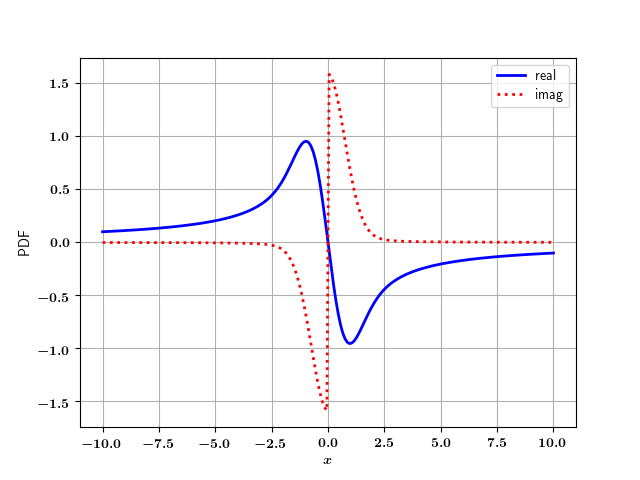

In [5]:
# --- Plot PDF along x-real ---
x_max = 10
Nx = 200
xr = np.linspace(-x_max, x_max, Nx)

x = xr + 1j*0.1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xr, np.real(PDFf_1D(x)),'b', linewidth = 2, linestyle='-', label='real')
ax.plot(xr, np.imag(PDFf_1D(x)),'r', linewidth = 2, linestyle=':', label='imag')
plt.xlabel('$x$')
plt.ylabel("PDF")
ax.legend()
plt.grid(True)
plt.show()

del xr, x_max, x, Nx, fig, ax

<IPython.core.display.Javascript object>


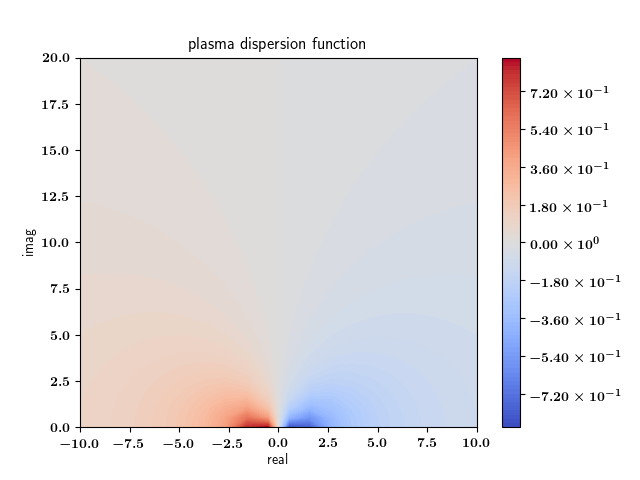

In [6]:
# --- Plot PDF in (x-real, x-imag) ---
x_max = 10
Nx = 20
xr = np.linspace(-x_max, x_max, Nx)
xi = np.linspace(0, 2*x_max, 2*Nx)

XX, YY = np.meshgrid(xr, xi)
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(XX, YY, np.real(PDFf_2D(XX + 1j*YY)), levels=100, cmap=cmap_two_signs_)
fig.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
ax.set_xlabel('real')
ax.set_ylabel('imag')
ax.set_title('plasma dispersion function')

del xr, xi, x_max, Nx, XX, YY, fig, cs, ax

In [11]:
# --- Plot dispersion relation ---
w = 0.8
k_max = 1
Nk = 20000
k = np.linspace(-k_max, k_max, Nk)


eps_res = eps_k(w,k)

norm_max = np.max(abs(eps_res))

re_eps = np.real(eps_res)/norm_max
im_eps = np.imag(eps_res)/norm_max

ir_eps = 1./re_eps
inv_norm = np.max(np.abs(ir_eps))
ir_eps = abs(ir_eps) / inv_norm


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k, re_eps,'b', linewidth = 2, linestyle='-', label='real')
ax.plot(k, im_eps,'r', linewidth = 2, linestyle=':', label='imag')
ax.plot(k, ir_eps,'black', linewidth = 2, linestyle=':', label='abs(1/real)')
plt.xlabel('$k$')
plt.ylabel("norm. epsilon")
ax.legend()
plt.grid(True)
plt.show()

del k, k_max, Nk, fig, ax, w

<IPython.core.display.Javascript object>

In [12]:
# --- Initial parameters ---
Nx = 1001
xmax = 60.0
x = np.linspace(-xmax, xmax, Nx, endpoint=False)
dx = np.diff(x)[0]

w = 0.8   # in plasma-frequency units
x0 = 0.0  # in Debye lengths
ds = 1.0  # in Debye lengths

coef_1 = 1.j * np.sqrt(2.*np.pi) * ds

source_k = lambda k: coef_1 * k * np.exp( -0.5 * k * (pow(ds,2) * k + 2 * 1j * x0) )  # Fourier of dipole

In [13]:
# --- Compute electric field in real space ---
N_points = 2
k_max_init, Nk_init = 10, 1000

coef_pi = 1. / (2.*np.pi)
 
# array_k_max = [k_max_init*ii for ii in range(1,N_points+1)]
array_k_max = [k_max_init for ii in range(1,N_points+1)]
array_Nk    = [Nk_init*ii for ii in range(1,N_points+1)]

array_Ex = [None]*N_points
for ik_max in range(len(array_k_max)):
    k_max = array_k_max[ik_max]
    Nk    = array_Nk[ik_max]
    k = np.linspace(-k_max,k_max,Nk)
    
    Ex = np.zeros(Nx, dtype=complex)
    for ix in range(Nx):
        x1 = x[ix]
        Ex[ix] = np.trapz(source_k(k) * np.exp(1j*k*x1) / (1j * k * eps_k(w,k)), k)
    array_Ex[ik_max] = coef_pi * Ex
    
del coef_pi

<IPython.core.display.Javascript object>


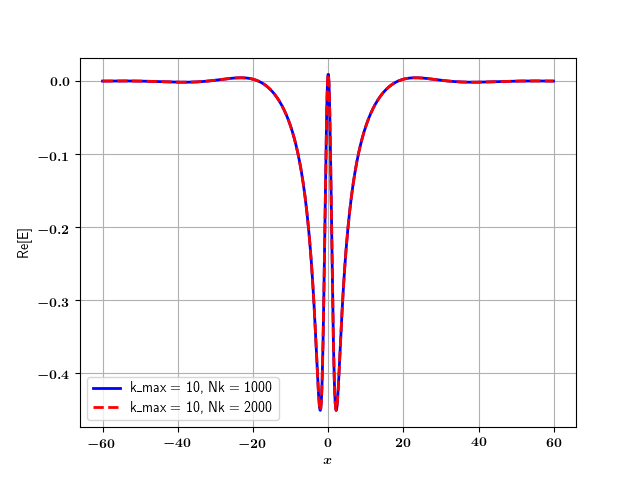

<IPython.core.display.Javascript object>


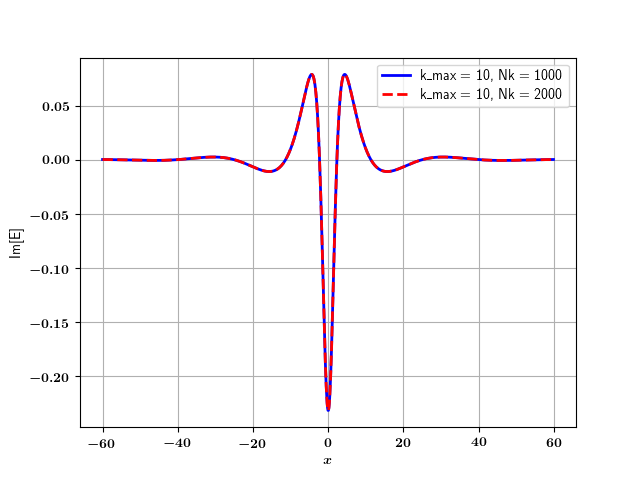

<IPython.core.display.Javascript object>


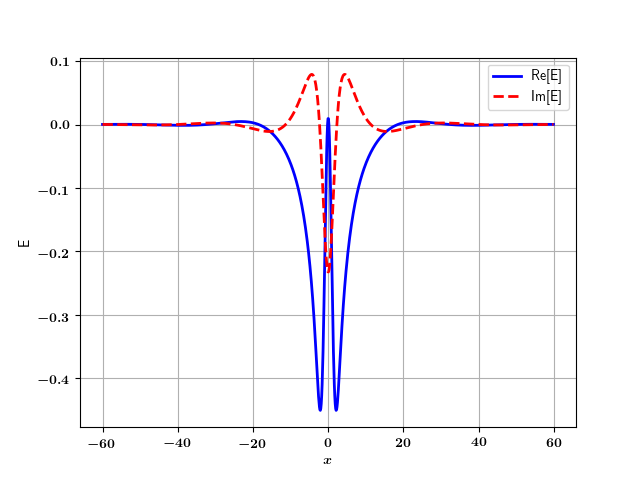

In [14]:
# --- Plot electric field in real space ---

# real of E: scan on various k-intervals
fig = plt.figure()
ax = fig.add_subplot(111)
for ik_max in range(len(array_k_max)):
    ax.plot(
        x, 
        np.real(array_Ex[ik_max]),
        colors_[ik_max], linewidth = 2, linestyle=lines_[ik_max], 
        label='k_max = {:d}, Nk = {:d}'.format(array_k_max[ik_max], array_Nk[ik_max])
    )
plt.xlabel('$x$')
plt.ylabel("Re[E]")
ax.legend()
plt.grid(True)
plt.show()

# imag of E: scan on various k-intervals
fig = plt.figure()
ax = fig.add_subplot(111)
for ik_max in range(len(array_k_max)):
    ax.plot(
        x, 
        np.imag(array_Ex[ik_max]),
        colors_[ik_max], linewidth = 2, linestyle=lines_[ik_max], 
        label='k_max = {:d}, Nk = {:d}'.format(array_k_max[ik_max], array_Nk[ik_max])
    )
plt.xlabel('$x$')
plt.ylabel("Im[E]")
ax.legend()
plt.grid(True)
plt.show()


# real and imag: for the last consideted k-interval
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, np.real(array_Ex[N_points-1]),'b', linewidth = 2, linestyle='-', label="Re[E]")
ax.plot(x, np.imag(array_Ex[N_points-1]),'r', linewidth = 2, linestyle='--', label="Im[E]")
plt.xlabel('$x$')
plt.ylabel("E")
ax.legend()
plt.grid(True)
plt.show()

In [15]:
# --------------------------------------------------------------
# --- Save data ---
# --------------------------------------------------------------
path_res = "/media/work/docs/codes/QuCF/results/KIN1D1D-results/figs/"

mix.save_dat_plot_1d_file(
    path_res + "/theory_Ere_w{:0.2f}.dat".format(w),    
    x, 
    np.real(array_Ex[N_points-1])
)
mix.save_dat_plot_1d_file(
    path_res + "/theory_Eim_w{:0.2f}.dat".format(w),    
    x, 
    np.imag(array_Ex[N_points-1])
)

del path_res

write data to a file: /media/work/docs/codes/QuCF/results/KIN1D1D-results/figs//theory_Ere_w0.80.dat
write data to a file: /media/work/docs/codes/QuCF/results/KIN1D1D-results/figs//theory_Eim_w0.80.dat


<IPython.core.display.Javascript object>


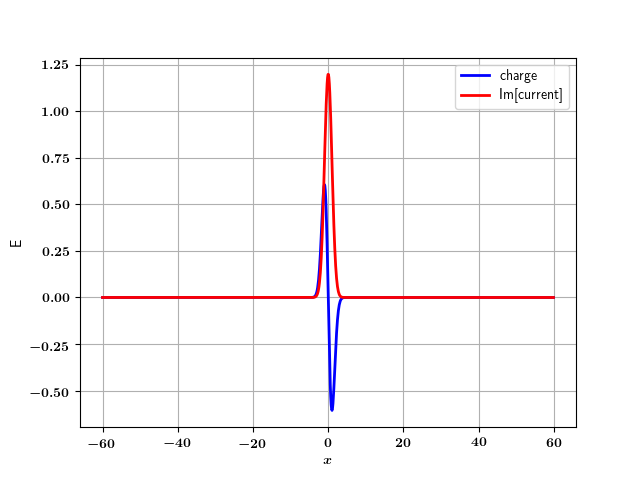

In [18]:
# --- Plot charge and current sources in space ---
Nx = 1001
xmax = 60.0
x = np.linspace(-xmax, xmax, Nx, endpoint=False)

w = 1.2   # in plasma-frequency units
x0 = 0.0  # in Debye lengths
ds = 1.0  # in Debye lengths

dx2 = pow(x-x0,2)
coef_ds = pow(ds,2)

source_charge = - (x - x0) / coef_ds * np.exp(-dx2/(2.*coef_ds))
source_current = 1j * w * np.exp(-dx2/(2.*coef_ds))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, source_charge,          'b', linewidth = 2, linestyle='-', label="charge")
ax.plot(x, np.imag(source_current),'r', linewidth = 2, linestyle='-', label="Im[current]")
plt.xlabel('$x$')
plt.ylabel("E")
ax.legend()
plt.grid(True)
plt.show()


del Nx, xmax, x, source_charge, source_current, ds, w, x0, dx2, coef_ds, fig, ax